# Advanced NLP - Project 1.1

In [ ]:
!pip install datasets transformers wordcloud nltk accelerate -q

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import string
import time

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [18]:
from datasets import load_dataset

dataset = load_dataset('ag_news')

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# map labels to names
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
train_df['category'] = train_df['label'].map(lambda x: label_names[x])
test_df['category'] = test_df['label'].map(lambda x: label_names[x])

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")
train_df.head()

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Training set: 120000 samples
Test set: 7600 samples


,text,label,category
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


---
## Task 1: Data Exploration
---

In [20]:
print("training set class distribution:")
print(train_df['category'].value_counts())

training set class distribution:
category
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


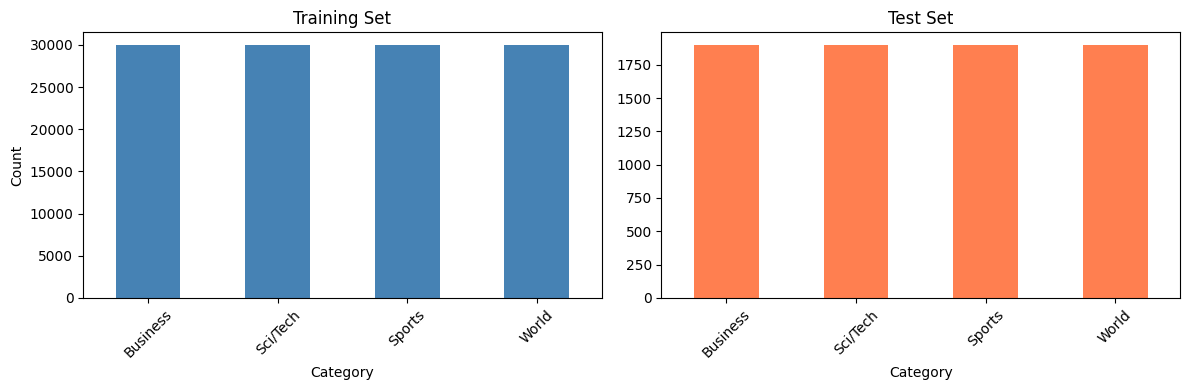

In [22]:
# class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_df['category'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Training Set')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

test_df['category'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Test Set')
axes[1].set_xlabel('Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

In [23]:
# text length
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['char_count'] = train_df['text'].apply(len)

print("Overall text length statistics:")
print(f"  Average word count: {train_df['word_count'].mean():.1f}")
print(f"  Median word count: {train_df['word_count'].median():.1f}")
print(f"  Min: {train_df['word_count'].min()}, Max: {train_df['word_count'].max()}")

Overall text length statistics:
  Average word count: 37.8
  Median word count: 37.0
  Min: 8, Max: 177


In [25]:
# text length per category
print("\nText length statistics by category:")
for cat in label_names:
    subset = train_df[train_df['category'] == cat]['word_count']
    print(f"  {cat}: mean={subset.mean():.1f}, median={subset.median():.1f}")


Text length statistics by category:
  World: mean=38.9, median=39.0
  Sports: mean=37.8, median=37.0
  Business: mean=37.5, median=37.0
  Sci/Tech: mean=37.2, median=36.0


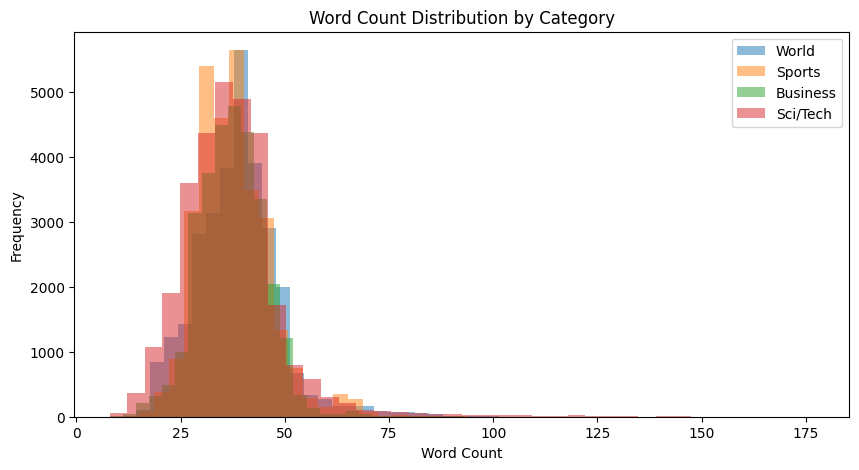

In [26]:
# word count distribution plot draw
fig, ax = plt.subplots(figsize=(10, 5))

for cat in label_names:
    data = train_df[train_df['category'] == cat]['word_count']
    ax.hist(data, bins=40, alpha=0.5, label=cat)

ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Word Count Distribution by Category')
ax.legend()
plt.savefig('word_count_dist.png', dpi=150)
plt.show()

In [31]:
# most frequent words per class

stop_words = set(stopwords.words('english'))

def get_top_words(texts, top_n=15):
    all_words = []
    for text in texts:
        text = text.replace("&#39;", "'").replace("39;s", "")
        words = text.lower().split()
        words = [w.strip(string.punctuation) for w in words]
        words = [w for w in words if w and w not in stop_words and len(w) > 2 and not w.isdigit() and "39" not in w]
        all_words.extend(words)
    return Counter(all_words).most_common(top_n)

print("Top 15 words per category:")
for cat in label_names:
    texts = train_df[train_df['category'] == cat]['text'].tolist()
    top_words = get_top_words(texts)
    words_only = [w[0] for w in top_words]
    print(f"\n{cat}: {words_only}")

Top 15 words per category:

World: ['said', 'iraq', 'reuters', 'president', 'new', 'afp', 'two', 'minister', 'killed', 'people', 'government', 'u.s', 'iraqi', 'prime', 'bush']

Sports: ['new', 'first', 'game', 'win', 'team', 'season', 'night', 'world', 'last', 'cup', 'one', 'two', 'victory', 'league', 'sunday']

Business: ['said', 'reuters', 'new', 'oil', 'inc', 'prices', 'company', 'percent', 'york', 'u.s', 'corp', 'million', 'profit', 'sales', 'stocks']

Sci/Tech: ['new', 'microsoft', 'said', 'software', 'reuters', 'internet', 'company', 'space', 'search', 'inc', 'computer', 'first', 'security', 'service', 'music']


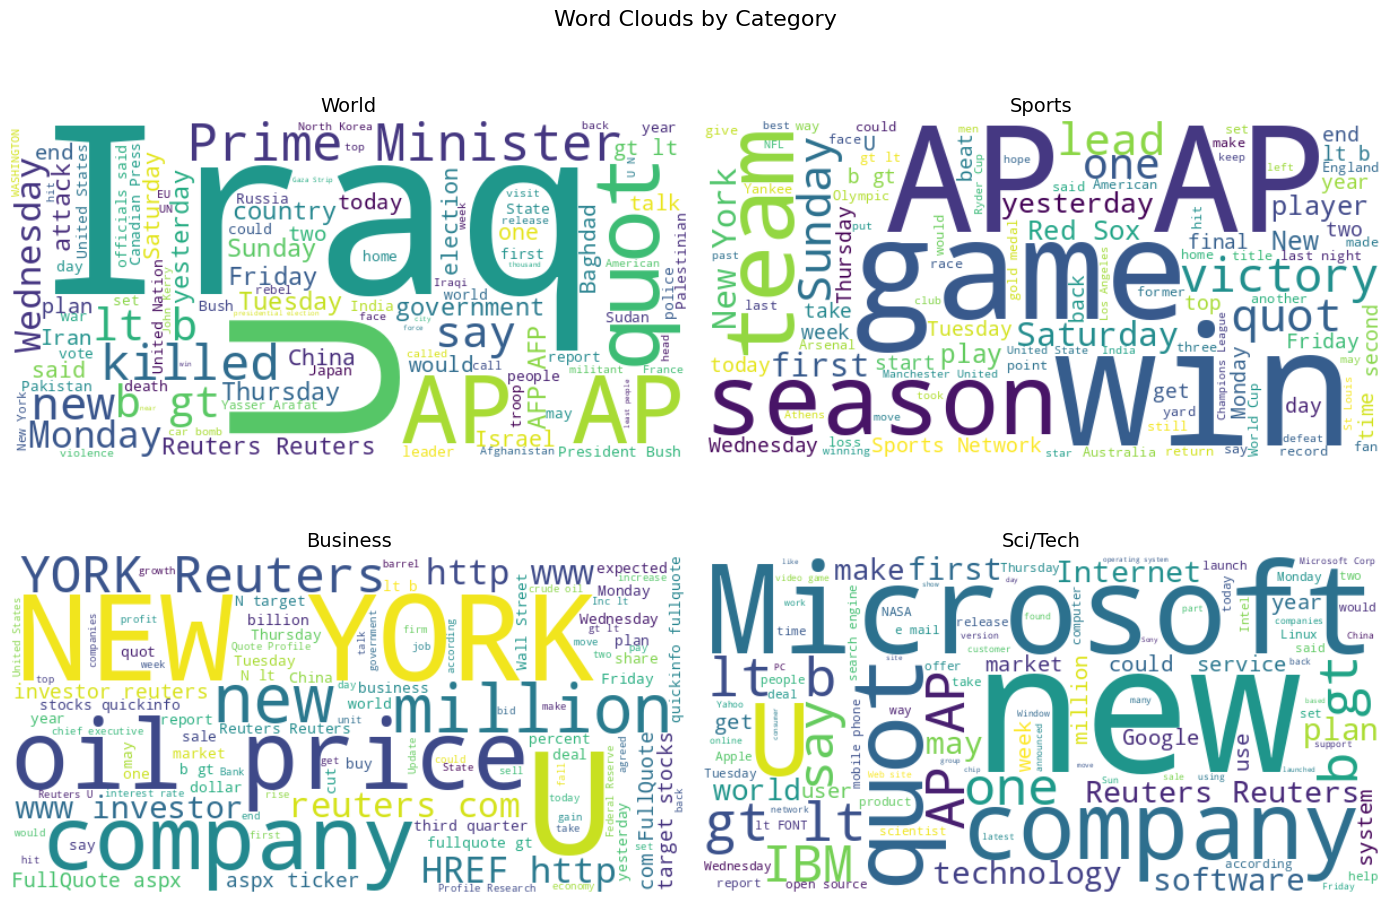

In [32]:
# word clouds for each category
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, cat in enumerate(label_names):
    text_combined = ' '.join(train_df[train_df['category'] == cat]['text'].tolist())
    wordcloud = WordCloud(
        width=600, height=300,
        background_color='white',
        stopwords=stop_words,
        max_words=100
    ).generate(text_combined)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(cat, fontsize=14)
    axes[i].axis('off')

plt.suptitle('Word Clouds by Category', fontsize=16)
plt.tight_layout()
plt.savefig('wordclouds.png', dpi=150)
plt.show()

In [34]:
# N-gram
def get_top_ngrams(texts, n=2, top_k=10):
    all_ngrams = []
    for text in texts:
        words = text.lower().split()
        words = [w.strip(string.punctuation) for w in words if w.strip(string.punctuation)]
        all_ngrams.extend(list(ngrams(words, n)))
    return Counter(all_ngrams).most_common(top_k)

print("Top bigrams per category:")
for cat in label_names:
    texts = train_df[train_df['category'] == cat]['text'].tolist()[:5000]  # subset for speed
    top_bigrams = get_top_ngrams(texts, n=2, top_k=5)
    print(f"\n{cat}:")
    for bg, count in top_bigrams:
        print(f"  '{bg[0]} {bg[1]}': {count}")

Top bigrams per category:

World:
  'in the': 1156
  'of the': 835
  'in a': 482
  'ap ap': 464
  'prime minister': 367

Sports:
  'in the': 1502
  'of the': 1200
  'at the': 652
  'ap ap': 564
  'for the': 526

Business:
  'in the': 682
  'new york': 605
  'oil prices': 562
  'of the': 561
  'york reuters': 358

Sci/Tech:
  'of the': 775
  'in the': 640
  'a new': 343
  'ap ap': 285
  'on the': 272


---
## Task 2: Preprocessing (15%)
---

In [35]:
class Preprocessor:
    """
    text preprocessing pipeline:
    - lowercase,
    - remove URLs and special chars,
    - tokenize,
    - remove stopwords and punctuation,
    - lemmatize
    """
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
        # lowercase
        text = text.lower()

        # remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)

        # tokenize
        tokens = word_tokenize(text)

        # remove stopwords, punctuation, numbers, and short words
        tokens = [
            self.lemmatizer.lemmatize(t)
            for t in tokens
            if t not in self.stop_words
            and t not in string.punctuation
            and not t.isdigit()
            and len(t) > 2
        ]

        return ' '.join(tokens)

In [36]:
# test the preprocessor
preprocessor = Preprocessor()

sample_text = train_df['text'].iloc[0]
print("Original:")
print(sample_text[:300])
print("\nPreprocessed:")
print(preprocessor.preprocess(sample_text)[:300])

Original:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Preprocessed:
wall st. bear claw back black reuters reuters short-sellers wall street dwindling\band ultra-cynics seeing green


In [38]:
# apply preprocessing to dataset
print("Preprocessing training data...")
train_df['processed'] = train_df['text'].apply(preprocessor.preprocess)

print("Preprocessing test data...")
test_df['processed'] = test_df['text'].apply(preprocessor.preprocess)

print("Done!")

Preprocessing training data...
Preprocessing test data...
Done!


---
## Task 3: Language Modeling
---

### 3.1 N-gram

In [39]:
# prepare data for language modeling - use subset for efficiency
lm_train_texts = train_df['processed'].tolist()[:15000]
lm_test_texts = test_df['processed'].tolist()[:1500]

In [40]:
class NGramModel:
    """N-gram language model with Laplace smoothing"""

    def __init__(self, n, smoothing=1.0):
        self.n = n
        self.smoothing = smoothing
        self.ngram_counts = defaultdict(int)
        self.context_counts = defaultdict(int)
        self.vocab = set()

    def train(self, texts):
        """Train the model on a list of texts"""
        for text in texts:
            tokens = ['<s>'] * (self.n - 1) + text.split() + ['</s>']
            self.vocab.update(tokens)

            for i in range(len(tokens) - self.n + 1):
                ngram = tuple(tokens[i:i+self.n])
                context = ngram[:-1]
                self.ngram_counts[ngram] += 1
                self.context_counts[context] += 1

        print(f"{self.n}-gram model trained: vocab size = {len(self.vocab)}, unique ngrams = {len(self.ngram_counts)}")

    def get_probability(self, ngram):
        """Get smoothed probability of ngram"""
        context = ngram[:-1]
        count = self.ngram_counts[ngram]
        context_count = self.context_counts[context]
        return (count + self.smoothing) / (context_count + self.smoothing * len(self.vocab))

    def perplexity(self, texts):
        """Calculate perplexity on test texts"""
        total_log_prob = 0
        total_count = 0

        for text in texts:
            tokens = ['<s>'] * (self.n - 1) + text.split() + ['</s>']
            for i in range(len(tokens) - self.n + 1):
                ngram = tuple(tokens[i:i+self.n])
                prob = self.get_probability(ngram)
                total_log_prob += np.log2(prob)
                total_count += 1

        return 2 ** (-total_log_prob / total_count)

    def generate(self, max_length=15):
        """Generate text using the model"""
        context = ['<s>'] * (self.n - 1)
        generated = []

        for _ in range(max_length):
            # Calculate probabilities for all possible next words
            probs = []
            vocab_list = list(self.vocab)
            for word in vocab_list:
                ngram = tuple(context + [word])
                probs.append(self.get_probability(ngram))

            probs = np.array(probs)
            probs = probs / probs.sum()

            # Sample next word
            next_word = np.random.choice(vocab_list, p=probs)

            if next_word == '</s>':
                break

            generated.append(next_word)
            context = context[1:] + [next_word]

        return ' '.join(generated)

In [41]:
# train bigram model
bigram = NGramModel(n=2, smoothing=1.0)
bigram.train(lm_train_texts)

# train trigram model
trigram = NGramModel(n=3, smoothing=1.0)
trigram.train(lm_train_texts)

2-gram model trained: vocab size = 28905, unique ngrams = 232155
3-gram model trained: vocab size = 28905, unique ngrams = 307094


In [42]:
# calculate perplexity
bigram_ppl = bigram.perplexity(lm_test_texts)
trigram_ppl = trigram.perplexity(lm_test_texts)

print(f"Bigram perplexity: {bigram_ppl:.2f}")
print(f"Trigram perplexity: {trigram_ppl:.2f}")

Bigram perplexity: 11937.72
Trigram perplexity: 20981.30


In [43]:
# generate text samples
print("\nBigram generated text:")
for i in range(3):
    print(f"  {i+1}. {bigram.generate(max_length=12)}")

print("\nTrigram generated text:")
for i in range(3):
    print(f"  {i+1}. {trigram.generate(max_length=12)}")


Bigram generated text:
  1. top tavarez 10.5 shewfelt indefinitely mad-cow standardization christopher flier sumitomo upon downplaying
  2. flatline mattered retires ducking pleasantly cheerleader marty lady 21st adewale record\high kidney
  3. cloud belgium smuggler demonstration anglo carrara expertly stunningly ornately rancor amr elderly

Trigram generated text:
  1. mattered revealed esperanza mozilla element 94\percent oar-some exacerbating halilhodzic billion\in 200,000 supposedly
  2. fleet prof trading\ranges frey baseball\monday jinx dolan vote 8-4 shyi-kun display dropped
  3. cash-and-debt jeb 'temporary scammed carnegie gullet urban gagne filed shorter-range state anti-cancer


### 3.2 Neural Language Model

In [45]:
# build vocabulary for neural model
word_counter = Counter()
for text in lm_train_texts:
    word_counter.update(text.split())

# keep most common words
vocab_size = 8000
min_freq = 2

neural_vocab = ['<pad>', '<unk>']
for word, count in word_counter.most_common(vocab_size - 2):
    if count >= min_freq:
        neural_vocab.append(word)

word_to_idx = {w: i for i, w in enumerate(neural_vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

print(f"Neural vocab size: {len(neural_vocab)}")

Neural vocab size: 8000


In [46]:
class LanguageModelDataset(Dataset):
    """Dataset for training language model"""
    def __init__(self, texts, word_to_idx, seq_length=25):
        self.seq_length = seq_length
        self.word_to_idx = word_to_idx

        # Encode all texts
        encoded = []
        for text in texts:
            for word in text.split():
                idx = word_to_idx.get(word, word_to_idx['<unk>'])
                encoded.append(idx)

        self.data = torch.tensor(encoded, dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.seq_length - 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + 1:idx + self.seq_length + 1]
        return x, y

In [47]:
class NeuralLanguageModel(nn.Module):
    """LSTM-based language model"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embed = self.embedding(x)
        lstm_out, _ = self.lstm(embed)
        out = self.dropout(lstm_out)
        return self.fc(out)

In [48]:
# create dataset and dataloader
seq_length = 25
batch_size = 64

train_dataset = LanguageModelDataset(lm_train_texts, word_to_idx, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LanguageModelDataset(lm_test_texts, word_to_idx, seq_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training sequences: {len(train_dataset)}")
print(f"Test sequences: {len(test_dataset)}")

Training sequences: 376402
Test sequences: 37554


In [49]:
# initialize model
embedding_dim = 128
hidden_dim = 256

neural_lm = NeuralLanguageModel(
    vocab_size=len(neural_vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(neural_lm.parameters(), lr=0.001)

print(f"Model parameters: {sum(p.numel() for p in neural_lm.parameters()):,}")

Model parameters: 3,475,264


In [51]:
# training loop
num_epochs = 5
start_time = time.time()

for epoch in range(num_epochs):
    neural_lm.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = neural_lm(batch_x)
        loss = criterion(output.view(-1, len(neural_vocab)), batch_y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(neural_lm.parameters(), 5)
        optimizer.step()

        epoch_loss += loss.item()

    # evaluate
    neural_lm.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = neural_lm(batch_x)
            test_loss += criterion(output.view(-1, len(neural_vocab)), batch_y.view(-1)).item()

    train_ppl = np.exp(epoch_loss / len(train_loader))
    test_ppl = np.exp(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train PPL: {train_ppl:.2f}, Test PPL: {test_ppl:.2f}")

training_time = time.time() - start_time
print(f"\nTraining time: {training_time:.1f} seconds")

Epoch 1/5 - Train PPL: 186.82, Test PPL: 560.70
Epoch 2/5 - Train PPL: 44.01, Test PPL: 834.35
Epoch 3/5 - Train PPL: 24.72, Test PPL: 1248.87
Epoch 4/5 - Train PPL: 17.97, Test PPL: 1767.78
Epoch 5/5 - Train PPL: 14.75, Test PPL: 2364.10

Training time: 316.3 seconds


In [52]:
# generate text with neural model
def generate_neural(model, seed_word, max_length=15, temperature=1.0):
    model.eval()
    tokens = [word_to_idx.get(seed_word, word_to_idx['<unk>'])]

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([tokens[-seq_length:]]).to(device)
            output = model(x)
            logits = output[0, -1] / temperature
            probs = torch.softmax(logits, dim=0)
            next_idx = torch.multinomial(probs, 1).item()

            if idx_to_word[next_idx] == '<pad>':
                break
            tokens.append(next_idx)

    return ' '.join([idx_to_word[t] for t in tokens])

print("Neural LM generated text:")
for seed in ['market', 'team', 'president']:
    print(f"  [{seed}] {generate_neural(neural_lm, seed)}")

Neural LM generated text:
  [market] market watchdog must wait oracle <unk> finish win bmw international open team top largely saturday night
  [team] team trip olympics thursday <unk> say came american athens reuters greece <unk> <unk> finished <unk> american
  [president] president purnomo yusgiantoro said monday need side bid <unk> <unk> <unk> <unk> data tainted <unk> blockade


In [53]:
# summary comparison
print("\n" + "="*50)
print("Language Model Comparison")
print("="*50)
print(f"{'Model':<20} {'Perplexity':<15} {'Training Time'}")
print("-"*50)
print(f"{'Bigram':<20} {bigram_ppl:<15.2f} {'< 1 sec'}")
print(f"{'Trigram':<20} {trigram_ppl:<15.2f} {'< 1 sec'}")
print(f"{'Neural (LSTM)':<20} {test_ppl:<15.2f} {f'{training_time:.1f} sec'}")


Language Model Comparison
Model                Perplexity      Training Time
--------------------------------------------------
Bigram               11937.72        < 1 sec
Trigram              20981.30        < 1 sec
Neural (LSTM)        2364.10         316.3 sec


---
## Task 4: Transformer Finetuning
---

In [54]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer
from transformers import Trainer, TrainingArguments
from datasets import Dataset as HFDataset

In [55]:
# prepare data splits
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=train_df['label']
)

X_test = test_df['text'].tolist()
y_test = test_df['label'].tolist()

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 108000, Val: 12000, Test: 7600


In [56]:
# compare tokenization approaches
print("Tokenization Comparison:")
print("="*50)

# WordPiece/DistilBERT
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# WordPiece/BERT - different vocabulary
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sample = "The company's market share increased significantly."
print(f"\nText: {sample}")
print(f"\nDistilBERT: {distilbert_tokenizer.tokenize(sample)}")
print(f"\nBERT: {bert_tokenizer.tokenize(sample)}")

Tokenization Comparison:


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Text: The company's market share increased significantly.

DistilBERT: ['the', 'company', "'", 's', 'market', 'share', 'increased', 'significantly', '.']

BERT: ['the', 'company', "'", 's', 'market', 'share', 'increased', 'significantly', '.']


In [57]:
# use DistilBERT tokenizer
tokenizer = distilbert_tokenizer

def tokenize_data(texts, labels, max_length=256):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length
    )
    return HFDataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })

print("Tokenizing datasets...")
train_encoded = tokenize_data(X_train, y_train)
val_encoded = tokenize_data(X_val, y_val)
test_encoded = tokenize_data(X_test, y_test)
print("Done!")

Tokenizing datasets...
Done!


In [58]:
# load model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=4
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 66,956,548


In [59]:
# define metrics function
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        'accuracy': accuracy_score(labels, predictions),
        'macro_f1': f1_score(labels, predictions, average='macro')
    }

# training configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=200,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded,
    eval_dataset=val_encoded,
    compute_metrics=compute_metrics
)

In [60]:
# train
print("Fine-tuning DistilBERT...")
trainer.train()

Fine-tuning DistilBERT...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.198500,0.173982,0.942083,0.942042
2,0.130200,0.196451,0.944833,0.944751
3,0.088900,0.233207,0.946500,0.946483


TrainOutput(global_step=20250, training_loss=0.16118916629273214, metrics={'train_runtime': 6894.4382, 'train_samples_per_second': 46.994, 'train_steps_per_second': 2.937, 'total_flos': 2.1460483989504e+16, 'train_loss': 0.16118916629273214, 'epoch': 3.0})

In [61]:
# evaluate on test set
print("\nTest Set Results:")
test_results = trainer.evaluate(test_encoded)
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Macro-F1: {test_results['eval_macro_f1']:.4f}")


Test Set Results:


Accuracy: 0.9450
Macro-F1: 0.9450


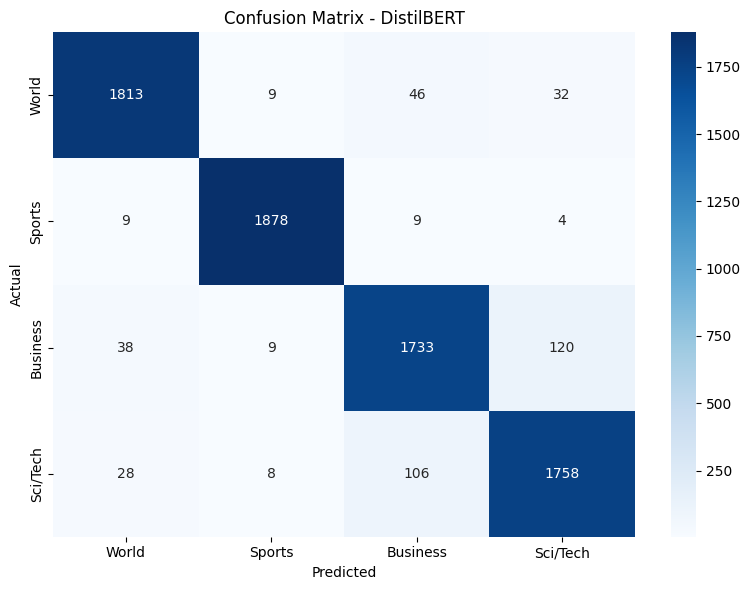


Classification Report:
              precision    recall  f1-score   support

       World       0.96      0.95      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.91      0.91      0.91      1900
    Sci/Tech       0.92      0.93      0.92      1900

    accuracy                           0.94      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.94      0.95      7600



In [62]:
# get predictions for confusion matrix
predictions = trainer.predict(test_encoded)
y_pred = np.argmax(predictions.predictions, axis=1)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

---
## Task 5: Model Evaluation and Benchmarking
---

In [63]:
# sample 100 test instances
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 100, replace=False)

sample_texts = [X_test[i] for i in sample_indices]
sample_true = [y_test[i] for i in sample_indices]
sample_pred = [y_pred[i] for i in sample_indices]

print(f"Sampled {len(sample_texts)} instances for evaluation")

Sampled 100 instances for evaluation


In [64]:
# 1. metric based evaluation (gold labels)
print("=" * 50)
print("1. Metric-Based Evaluation (Gold Labels)")
print("=" * 50)

sample_accuracy = accuracy_score(sample_true, sample_pred)
sample_f1 = f1_score(sample_true, sample_pred, average='macro')

print(f"Accuracy: {sample_accuracy:.4f}")
print(f"Macro-F1: {sample_f1:.4f}")

1. Metric-Based Evaluation (Gold Labels)
Accuracy: 0.9600
Macro-F1: 0.9603


In [65]:
# 2. human evaluation - display samples for manual rating
print("\n" + "=" * 50)
print("2. Human Evaluation - Samples to Rate")
print("=" * 50)

for i in range(10):
    print(f"\n--- Sample {i+1} ---")
    print(f"Text: {sample_texts[i][:200]}...")
    print(f"Model Prediction: {label_names[sample_pred[i]]}")
    print(f"Gold Label: {label_names[sample_true[i]]}")
    match = "✓" if sample_pred[i] == sample_true[i] else "✗"
    print(f"Match: {match}")


2. Human Evaluation - Samples to Rate

--- Sample 1 ---
Text: Fan v Fan: Manchester City-Tottenham Hotspur This weekend Manchester City entertain Spurs, and with last seasons seven-goal FA Cup epic between the two teams still fresh in the memory, entertain could...
Model Prediction: Sports
Gold Label: Sports
Match: ✓

--- Sample 2 ---
Text: Paris Tourists Search for Key to 'Da Vinci Code' (Reuters) Reuters - A funny thing happened on the way to the\Mona Lisa. Visitors to the Louvre museum in Paris, home of the\world's most famous paintin...
Model Prediction: World
Gold Label: World
Match: ✓

--- Sample 3 ---
Text: Net firms: Don't tax VoIP The Spanish-American War is over and a "temporary" tax created to pay for it should not be extended to Internet phone calls, industry groups tell the IRS...
Model Prediction: Sci/Tech
Gold Label: Sci/Tech
Match: ✓

--- Sample 4 ---
Text: Dependent species risk extinction The global extinction crisis is worse than thought, because thousands of  quot;

In [66]:
# 3. LLM-as-a-judge evaluation
print("\n" + "=" * 50)
print("3. LLM-as-a-Judge Evaluation")
print("=" * 50)

judge_prompt = """Evaluate if this news article classification is correct.

Categories: World, Sports, Business, Sci/Tech

Article: {article}

Predicted Category: {prediction}

Is this classification correct? Answer CORRECT or INCORRECT with a brief explanation."""

print("\nExample prompt for LLM judge:")
example_prompt = judge_prompt.format(
    article=sample_texts[0][:300],
    prediction=label_names[sample_pred[0]]
)
print(example_prompt)

# To run with local LLM (e.g., Ollama with Llama 3.1 8B):
# import ollama
#
# def llm_judge(article, prediction):
#     prompt = judge_prompt.format(article=article[:400], prediction=prediction)
#     response = ollama.chat('llama3.1:8b', messages=[{'role': 'user', 'content': prompt}])
#     return 'CORRECT' in response['message']['content'].upper()
#
# llm_results = []
# for i in range(len(sample_texts)):
#     result = llm_judge(sample_texts[i], label_names[sample_pred[i]])
#     llm_results.append(result)
# llm_accuracy = sum(llm_results) / len(llm_results)


3. LLM-as-a-Judge Evaluation

Example prompt for LLM judge:
Evaluate if this news article classification is correct.

Categories: World, Sports, Business, Sci/Tech

Article: Fan v Fan: Manchester City-Tottenham Hotspur This weekend Manchester City entertain Spurs, and with last seasons seven-goal FA Cup epic between the two teams still fresh in the memory, entertain could be the operative word.

Predicted Category: Sports

Is this classification correct? Answer CORRECT or INCORRECT with a brief explanation.


In [67]:
# summary table
print("\n" + "=" * 50)
print("Evaluation Methods Comparison")
print("=" * 50)
print(f"{'Method':<30} {'Accuracy'}")
print("-" * 50)
print(f"{'Metric-based (Gold Labels)':<30} {sample_accuracy:.4f}")
print(f"{'Human Evaluation':<30} [Fill after manual rating]")
print(f"{'LLM-as-Judge':<30} [Fill after running LLM]")


Evaluation Methods Comparison
Method                         Accuracy
--------------------------------------------------
Metric-based (Gold Labels)     0.9600
Human Evaluation               [Fill after manual rating]
LLM-as-Judge                   [Fill after running LLM]


---
## Final Summary
---

In [68]:
print("#" * 60)
print("PROJECT SUMMARY")
print("#" * 60)

print(f"\nDataset: AG News")
print(f"  Training samples: {len(train_df)}")
print(f"  Test samples: {len(test_df)}")
print(f"  Classes: {label_names}")
print(f"  Average text length: {train_df['word_count'].mean():.1f} words")

print(f"\nLanguage Models:")
print(f"  Bigram perplexity: {bigram_ppl:.2f}")
print(f"  Trigram perplexity: {trigram_ppl:.2f}")
print(f"  Neural LM perplexity: {test_ppl:.2f}")

print(f"\nClassifier (DistilBERT):")
print(f"  Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"  Test Macro-F1: {test_results['eval_macro_f1']:.4f}")

print("\n" + "#" * 60)

############################################################
PROJECT SUMMARY
############################################################

Dataset: AG News
  Training samples: 120000
  Test samples: 7600
  Classes: ['World', 'Sports', 'Business', 'Sci/Tech']
  Average text length: 37.8 words

Language Models:
  Bigram perplexity: 11937.72
  Trigram perplexity: 20981.30
  Neural LM perplexity: 2364.10

Classifier (DistilBERT):
  Test Accuracy: 0.9450
  Test Macro-F1: 0.9450

############################################################
